# Đồ án cuối kì - Nhập môn khoa học dữ liệu
### Nhóm 16


## 1. Thu thập dữ liệu

Khai báo thư viện

In [1]:
import sys
sys.executable

#import pycountry_convert as pc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_theme()

# remove warnings
import warnings
warnings.simplefilter('ignore')

## 2. Tiền xử lý và khám phá dữ liệu

### Đọc dữ liệu

In [2]:
df = pd.read_csv('data.csv')
display(df.head())
print(df.shape)

,Cause of death,Age,Year,Country,Number of deaths
0,HIV/AIDS,0,2020,Albania,NaN
1,HIV/AIDS,0,2020,Antigua and Barbuda,NaN
2,HIV/AIDS,0,2020,Argentina,NaN
3,HIV/AIDS,0,2020,Armenia,NaN
4,HIV/AIDS,0,2020,Australia,0


(262752, 5)


### Mỗi dòng có ý nghĩa gì? Có vấn đề các dòng có ý nghĩa khác nhau không?

Mỗi dòng cho biết với mỗi nguyên nhân, nhóm tuổi, năm và quốc gia thì có bao nhiêu người chết. Không có vấn đề các dòng có ý nghĩa khác nhau

### Dữ liệu có các dòng bị lặp không?

Ta sẽ kiểm tra vụ này và lưu kết quả vào biến `have_duplicated_rows`. Biến này sẽ có giá trị True nếu dữ liệu có các dòng bị lặp và có giá trị False nếu ngược.

In [3]:
have_duplicated_rows = df.duplicated().sum()

In [4]:
# TEST
assert have_duplicated_rows == False

Kết quả kiểm tra cho thấy không có dòng nào là bị trùng lắp dữ liệu cả.

### Mỗi cột có ý nghĩa gì?

Dưới đây là phần mô tả thông tin về các cột trong file "data.csv" mà nhóm đã lấy về được:
- **Cause of death**: Tên của nguyên nhân gây tử vong.
- **Age**: Nhóm tuổi tử vong.
- **Year**: Năm tử vong.
- **Country**: Quốc gia ghi nhận ca tử vong đó.
- **Number of deaths**: Số lượng tử vong.

In [52]:
df['Number of deaths'].describe()

count     207240
unique      3900
top            0
freq       95353
Name: Number of deaths, dtype: object

### Mỗi cột hiện đang có kiểu dữ liệu gì? Có cột nào có kiểu dữ liệu chưa phù hợp để có thể xử lý tiếp không?

Ta lấy `dtype` (kiểu dữ liệu của mỗi phần tử) của mỗi cột trong dữ liệu và lưu kết quả vào series `col_dtypes`; series này có index là tên cột. 

In [5]:
col_dtypes = df.dtypes
col_dtypes

Cause of death      object
Age                 object
Year                 int64
Country             object
Number of deaths    object
dtype: object

Ta thấy cột "Cause of death" và "Country" có kiểu `object` là hợp lý rồi, cột "Age" có kiểu `object` thì cũng chấp nhận được. Nhưng 2 cột "Year" và "Number of deaths" có kiểu dữ liệu chưa phù hợp; "Year" phải có kiểu là `datatime` còn "Number of deaths" phải có kiểu là `int`

**Chuyển dtype của cột "Year" sang `datetime`**

Cột "Year" đang có dtype là `int64`, ta sẽ thực hiện bước tiền xử lý để chuyển sang dạng `datetime`.

In [6]:
df['Year'] = pd.to_datetime(df['Year'], format='%Y')

In [7]:
# TEST
assert df.dtypes['Year'] == np.dtype('datetime64[ns]')

**Chuyển dtype của cột "Number of deaths" sang `float`**

Tại sao không phải kiểu `int` mà lại là `float` ?

Ta chuyển về kiểu `float` chỉ là tạm thời, vì trong cột "Number of deaths" có giá trị NAN nên ta không thể chuyển về kiểu `int` được. Ta sẽ sẽ chuyển về `int` ở phía dưới sau khi đã xóa NAN

Cột "Number of deaths" đang có dtype là `object`. Trong Pandas, kiểu dữ liệu `object` thường ám chỉ chuỗi, nhưng thật ra kiểu dữ liệu `object` có thể chứa một đối tượng bất kỳ trong Python (vì thật ra ở bên dưới kiểu dữ liệu `object` chứa địa chỉ). Nếu một cột trong dataframe có `dtype` là `object` thì có thể các phần tử trong cột này sẽ có kiểu dữ liệu khác nhau.

Ta xem chi tiết kiểu dữ liệu cột `Number of deaths`

In [8]:
def open_object_dtype(s):
    dtypes = set()

    dtypes = set(s.apply(type))
    
    return dtypes

In [9]:
open_object_dtype(df['Number of deaths'])

{float, str}

Ta tiến hành xóa ' ' trong các giá trị của cột "Number of deaths" và đổi kiểu dữ liệu thành `float`.

In [10]:
# Xóa khoảng trắng giữa các giá trị cột Number of deaths, ví dụ 1 084 -> 1084

df['Number of deaths'] = df['Number of deaths'].str.replace(' ', '').astype(float)

Ta kiểu tra lại kiểu dữ liệu của các cột sau khi chuyển đổi

In [11]:
col_dtypes = df.dtypes
col_dtypes

Cause of death              object
Age                         object
Year                datetime64[ns]
Country                     object
Number of deaths           float64
dtype: object

### Với mỗi cột có kiểu dữ liệu dạng số (numerical), các giá trị được phân bố như thế nào?

Ta sẽ xếp các cột datetime vào nhóm numeric luôn. Như vậy, ta có 2 cột numeric là: "Year" và "Number of deaths"

Với mỗi cột numeric ta sẽ tính tỉ lệ % giá trị thiếu (từ 0 đến 100), min, max. Kết quả sẽ được lưu vào dataframe nume_col_profiles_df. Dataframe này có 3 dòng là "missing_ratio", "min", "max"; và có 2 cột là "Year" và "Number of deaths".

In [12]:
nume_col_df = df[["Year", "Number of deaths"]]

data = {"missing_ratio": nume_col_df.isna().mean() * 100,
        "min": nume_col_df.min(),
        "max": nume_col_df.max()}

nume_col_profiles_df = pd.DataFrame(data).T

nume_col_profiles_df

,Year,Number of deaths
missing_ratio,0.0,21.313254
min,2000-01-01 00:00:00,0.0
max,2020-01-01 00:00:00,206559.0


**Có gì bất thường không?**

### Với mỗi cột có kiểu dữ liệu dạng phân loại (categorical), các giá trị được phân bố như thế nào?

df có 3 cột categorical là: "Cause of death", "Age", "Country".

Với mỗi cột categorical, ta tính tỉ lệ % giá trị thiếu (từ 0 đến 100), số lượng giá trị khác nhau (không xét giá trị thiếu), list các giá trị khác nhau (không xét giá trị thiếu). Ta lưu kết quả vào dataframe cate_col_profiles_df. Dataframe này có 3 dòng là "missing_ratio", "num_diff_vals", "diff_vals"; và có 3 cột là "Cause of death", "Age", "Country".

In [13]:
cate_col_df = df[["Cause of death", "Age", "Country"]]
cate_col_profiles_dict = {}

for col in cate_col_df:
    missing_ratio = cate_col_df[col].isna().mean()*100
    diff_vals = list(cate_col_df[col].value_counts(dropna=True).index)
    num_diff_vals = len(diff_vals)
    
    cate_col_profiles_dict[col] = {"missing_ratio": missing_ratio,
                                   "num_diff_vals": num_diff_vals,
                                   "diff_vals": diff_vals}

cate_col_profiles_df = pd.DataFrame(cate_col_profiles_dict)

cate_col_profiles_df

,Cause of death,Age,Country
missing_ratio,0.0,0.0,0.0
num_diff_vals,14,8,113
diff_vals,"[HIV/AIDS, Malaria, Tuberculosis, Brain and ne...","[0, 1-4, 5-14, 15-24, 25-34, 35-54, 55-74, 75+]","[Kuwait, Montenegro, Portugal, Poland, Philipp..."


**Có gì bất thường không?**

### Tiền xử lý

Các dòng có giá trị tại cột "Cause of death" bằng 0 hoặc NAN sẽ không có ý nghĩa cho thống kê dữ liệu, vì vậy ta sẽ tiến hành xóa các dòng này. Sau đó chuyển kiểu dữ liệu của cột "Cause of death" về `int` như đã nói ở trên

In [39]:
df = df[df['Number of deaths'] != 0.0].dropna().astype({'Number of deaths': int})
df

,Cause of death,Age,Year,Country,Number of deaths
33,HIV/AIDS,0,2020-01-01,Estonia,1
38,HIV/AIDS,0,2020-01-01,Georgia,1
43,HIV/AIDS,0,2020-01-01,Guatemala,1
67,HIV/AIDS,0,2020-01-01,Mexico,14
109,HIV/AIDS,0,2020-01-01,United States of America,2
...,...,...,...,...,...
261975,War,75+,2007-01-01,Sri Lanka,14
262010,War,75+,2006-01-01,Colombia,3
262028,War,75+,2006-01-01,Germany,1
262084,War,75+,2006-01-01,Sri Lanka,9


=============================================================================================

#### Chia 'Number of deaths' theo 'Cause death' và gom nhóm theo 'Country', 'Year' và 'Age'
- Thay các giá trị Nan bằng giá trị 0 vì Nan hay cũng đều không có ý nghĩa cho thống kê dữ liệu, thay thế để dễ dàng có các bước trả lời câu hỏi hơn.

In [17]:
cause_death = df['Cause of death'].unique() # danh sách cause death
df = pd.pivot_table(df, values='Number of deaths', index=['Country', 'Year', 'Age'], columns=['Cause of death'], aggfunc=np.sum, fill_value=0).reset_index()
df = df.rename_axis(None, axis=1)
display(df.head(10))
print(f'{df.shape[0]} rows x {df.shape[1]} columns')
print(f'Nguyên nhân tử vong ({len(cause_death)}):')
print(*cause_death, sep='\n')

,Country,Year,Age,Brain and nervous system cancers,Covid-19,Dengue,Drownings,Fires,HIV/AIDS,Leukaemia,Malaria,Natural disasters,Road traffic accidents,Self-inflicted injuries,Tuberculosis,Violence,War
0,Albania,2000-01-01,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1
1,Albania,2000-01-01,1-4,0,0,0,12,1,0,3,0,0,0,0,2,0,0
2,Albania,2000-01-01,15-24,4,0,0,4,2,0,10,0,3,6,11,0,29,0
3,Albania,2000-01-01,25-34,6,0,0,5,0,0,9,0,1,13,20,0,34,0
4,Albania,2000-01-01,35-54,33,0,0,4,1,0,18,0,1,15,9,4,35,0
5,Albania,2000-01-01,5-14,2,0,0,7,0,0,8,0,2,6,1,1,1,0
6,Albania,2000-01-01,55-74,55,0,0,1,1,0,38,0,1,9,10,6,11,0
7,Albania,2000-01-01,75+,8,0,0,1,1,0,9,0,0,0,3,3,3,0
8,Albania,2001-01-01,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0
9,Albania,2001-01-01,1-4,2,0,0,11,0,0,5,0,0,7,0,0,2,0


18984 rows x 17 columns
Nguyên nhân tử vong (14):
HIV/AIDS
Malaria
Tuberculosis
Dengue
Covid-19
Brain and nervous system cancers
Leukaemia
Road traffic accidents
Fires
Drownings
Natural disasters
Self-inflicted injuries
Violence
War


In [18]:
#df.describe()

Đếm số dòng có giá trị 0 của các cột 'Country', 'Year', 'Age'

In [19]:
print('Country: ', (df.Country == 0).sum())
print('Year   : ', (df.Year == 0).sum())
print('Age    : ', (df.Age == 0).sum())

Country:  0
Year   :  0
Age    :  0


Như vậy, chỉ có những cột nguyên nhân tử vong có chứa giá trị 0. </br>
Một dòng mà dữ liệu chỉ chứa giá trị 0 thì dòng đó không có ý nghĩa.</br>
==> Loại bỏ những dòng này.

In [20]:
print('Kích thước trước khi xoá: ', df.shape)
df = df[(df == 0).sum(1) < len(cause_death)]
df.reset_index(drop=True, inplace=True)
print('Kích thước sau khi xoá  : ', df.shape)


Kích thước trước khi xoá:  (18984, 17)
Kích thước sau khi xoá  :  (14749, 17)


#### Thêm cột tên khu vực của quốc gia

In [21]:
# các quốc gia không được hỗ trợ bởi thư viện
exceptive_countries = {
    'China, Hong Kong SAR': 'Asia',
    'Iran (Islamic Republic of)': 'Asia',
    'Republic of Korea': 'Asia'
}

def country_to_continent(country_name):
    if country_name in exceptive_countries:
        return exceptive_countries[country_name]

    country_alpha2 = pc.country_name_to_country_alpha2(country_name)
    country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
    country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
    return country_continent_name

df.insert(loc = 0, column = 'Continent', value = df.Country.apply(country_to_continent))

continents = df.Continent.unique() # danh sách các khu vực
print(f'Các khu vực ({len(continents)}):')
print(*continents, sep='\n')

Các khu vực (6):
Europe
North America
South America
Asia
Oceania
Africa


Ví dụ một phần của dữ liệu

In [22]:
df.query("Country == 'Italy' and '2015' in Year ") # Dữ liệu Italy năm 2015

,Continent,Country,Year,Age,Brain and nervous system cancers,Covid-19,Dengue,Drownings,Fires,HIV/AIDS,Leukaemia,Malaria,Natural disasters,Road traffic accidents,Self-inflicted injuries,Tuberculosis,Violence,War
6743,Europe,Italy,2015-01-01,0,3,0,0,0,0,0,4,0,0,7,0,0,2,0
6744,Europe,Italy,2015-01-01,1-4,13,0,0,5,0,0,20,0,0,11,0,1,1,0
6745,Europe,Italy,2015-01-01,15-24,38,0,0,27,5,3,57,0,7,452,195,1,38,0
6746,Europe,Italy,2015-01-01,25-34,57,0,0,35,7,29,66,0,6,429,335,7,61,0
6747,Europe,Italy,2015-01-01,35-54,657,0,0,70,34,401,358,1,33,932,1383,31,166,0
6748,Europe,Italy,2015-01-01,5-14,39,0,0,10,0,0,48,0,0,25,13,1,2,0
6749,Europe,Italy,2015-01-01,55-74,2011,0,0,120,51,222,1737,0,15,821,1237,65,81,0
6750,Europe,Italy,2015-01-01,75+,1320,0,0,82,134,49,3745,1,2,750,825,226,44,0


In [23]:
df[df['Continent']=='Europe']

,Continent,Country,Year,Age,Brain and nervous system cancers,Covid-19,Dengue,Drownings,Fires,HIV/AIDS,Leukaemia,Malaria,Natural disasters,Road traffic accidents,Self-inflicted injuries,Tuberculosis,Violence,War
0,Europe,Albania,2000-01-01,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1
1,Europe,Albania,2000-01-01,1-4,0,0,0,12,1,0,3,0,0,0,0,2,0,0
2,Europe,Albania,2000-01-01,15-24,4,0,0,4,2,0,10,0,3,6,11,0,29,0
3,Europe,Albania,2000-01-01,25-34,6,0,0,5,0,0,9,0,1,13,20,0,34,0
4,Europe,Albania,2000-01-01,35-54,33,0,0,4,1,0,18,0,1,15,9,4,35,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14152,Europe,United Kingdom,2019-01-01,25-34,108,0,0,38,9,3,60,0,1,245,1023,3,71,0
14153,Europe,United Kingdom,2019-01-01,35-54,739,0,1,72,54,77,251,2,2,409,2268,28,118,0
14154,Europe,United Kingdom,2019-01-01,5-14,62,0,0,5,2,0,43,1,0,27,16,0,8,0
14155,Europe,United Kingdom,2019-01-01,55-74,2264,0,0,49,81,46,1578,8,2,400,1325,66,36,0


## 3. Đặt các câu hỏi có ý nghĩa cần trả lời

Sau khi đã khám phá dữ liệu và hiểu hơn về dữ liệu, ta thấy có một số câu hỏi có thể được trả lời bằng dữ liệu:
- Thế giới vừa gánh chịu hậu quả to lớn mà đại dịch Covid_19 vừa đem đến, ta sẽ tiến hành xử lý và tìm ra top 3 quốc gia có số lượng tử vong vì Covid nhiều nhất?
    
        Ý nghĩa: với câu hỏi trên, ta biết được những quốc gia có số lượng tử vong vì Covid nhiều nhất. Tử vong nhiều như thế chứng tỏ nỗi mất mác của quốc gia rất nặng nề. Ta đánh giá mục đích có những quan tâm giúp đỡ để bù đắp phần nào về nỗi đau của họ. Bên cạnh đó, việc tử vong nhiều là do công tác phòng chống dịch bệnh Covid của họ vẫn còn nhiều khiếm khuyết, ta cần đưa ra cá giải pháp hỗ trợ về mặt y tế cho các quốc gia này.

### Top 3 quốc gia có số lượng tử vong vì Covid nhiều nhất?

Để trả lời cho câu hỏi này, ta sẽ làm như sau:
- Bước 1: Tính số lượng ca tử vong theo từng nhóm tuổi. Chọn ra top 3 quốc gia có tổng số ca tử vong nhiều nhất. Ta lưu kết quả vào series `num_death_covid`.
- Bước 2: Từ kết quả ở trên, ta vẽ group stack bar chart, trong đó trục hoành là số ca tử vong và trục tung là quốc gia. Ta đặt tên trục hoành là "Num_deaths" và tên trục tung là "Country".

Code bước 1. 

In [24]:
#Lọc ra các nước bắt đầu có ca tử vong do Covid
mask= df['Covid-19']>0

#Nhóm các quốc gia theo độ tuổi để tính tổng ca tử vong
num_death_covid=df[mask].groupby(['Country','Age'])['Covid-19'].sum()
num_death_covid=num_death_covid.reset_index()
num_death_covid = num_death_covid.pivot_table(index="Country", columns="Age",values='Covid-19', fill_value=0)
num_death_covid['sum_cols'] = num_death_covid.sum(axis=1)
num_death_covid = num_death_covid.sort_values('sum_cols' , ascending=False)
num_death_covid = num_death_covid.drop(columns='sum_cols').head(3)
display(num_death_covid)

Age,0,1-4,15-24,25-34,35-54,5-14,55-74,75+
Country,,,,,,,,
United States of America,35,19,501,2254,23043,49,118367,206559
Mexico,209,111,926,4534,45906,150,103836,44530
Spain,4,1,24,93,1442,5,12731,60539


Code bước 2. 

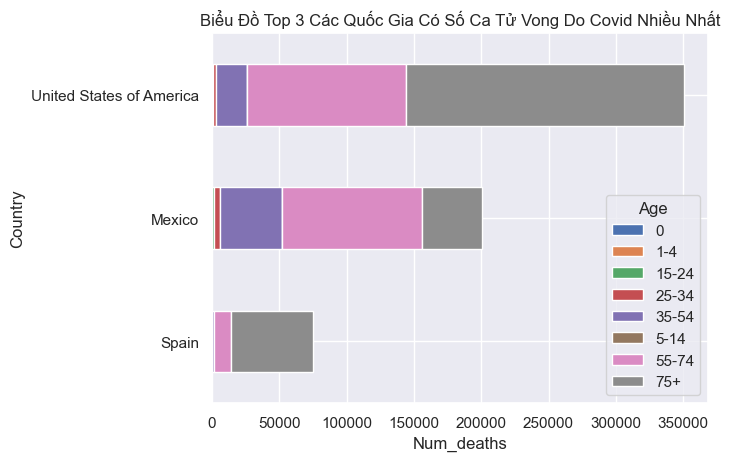

In [25]:
ax = num_death_covid.plot.barh(stacked=True)
plt.xlabel('Num_deaths')
plt.ylabel('Country')
plt.title('Biểu Đồ Top 3 Các Quốc Gia Có Số Ca Tử Vong Do Covid Nhiều Nhất')
plt.gca().invert_yaxis()
plt.show()